In [1]:
from hipecta.data import ctaTelescope2Matrix
from hipecta import core
import numpy as np
import h5py
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, ConcatDataset, sampler
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import hipecta.plots as plots
from torchvision import transforms, utils
import math
import time
import os
import sys

converter_path = os.path.abspath(os.path.join('/home/jacquemont/GammaLearn/converter_hdf5'))
if converter_path not in sys.path:
    sys.path.append(converter_path)
    
from converter_hdf5 import *
from datasets import *

In [2]:
class CNNModelLST(nn.Module):
    def __init__(self):
        super(CNNModelLST, self).__init__()
        # conv1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu1 = nn.ReLU()
        # maxpooling 1, by default floor
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm1 = nn.BatchNorm2d(16)
        
        # conv2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu2 = nn.ReLU()
        # maxpooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # batch norm
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        # conv3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu3 = nn.ReLU()
        # maxpooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        # conv4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu4 = nn.ReLU()
        # maxpooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm4 = nn.BatchNorm2d(128)
        
        # conv5
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0)
        # non-linearity
        self.relu5 = nn.ReLU()
        
        # readout, regression of energy, altitude, azimuth, xCore, yCore
        #self.fc1 = nn.Linear(128, 5)
         # readout, regression of xCore and yCore
        self.fc1 = nn.Linear(128, 2)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform(m.weight.data, mode='fan_out')
                
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.batchnorm1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.batchnorm2(out)
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)
        out = self.batchnorm3(out)
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)
        out = self.batchnorm4(out)
        out = self.conv5(out)
        out = self.relu5(out)

        # Reshape out from 100,128,1 to 100,128
        out = out.view(out.size(0),-1)
        
        out = self.fc1(out)
        return out

In [3]:
test_file = '/home/jacquemont/projets_CTA/gamma0.hdf5'
f = h5py.File(test_file, 'r')
injTable = np.array(f['/Cameras/LSTCAM/injTable'])
nbRow = f['/Cameras/LSTCAM'].attrs['nbRow']
nbCol = f['/Cameras/LSTCAM'].attrs['nbCol']
test_dataset = LSTCamDataset(hdf5_file=f,
                             transform=transforms.Compose([
                                 TelescopeToSquareMatrix(injTable, nbRow, nbCol),
                                 ToTensor()
                             ]))

test_dataset_2 = LSTCamDataset(hdf5_file=f)

test_dataset_3 = ConcatDataset([test_dataset, test_dataset_2])


In [4]:
# Creation of subset train and test
random_indices = torch.randperm(len(test_dataset))
train_max_index = int(len(test_dataset)*0.9)
train_set_sampler = sampler.SubsetRandomSampler(random_indices[0:train_max_index])
test_set_sampler = sampler.SubsetRandomSampler(random_indices[train_max_index + 1:])

batch_size = 16
n_iters = 12000
num_epochs = int(n_iters/(len(test_dataset)*0.9/batch_size))
print(num_epochs)

# iterable subset creation
train_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           sampler=train_set_sampler)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          sampler=test_set_sampler)

21


In [5]:
if torch.cuda.is_available():
    print("CUDA available")

CUDA available


In [10]:
model = CNNModelLST()
model.double()
onGPU = True

## Run on GPU ##
if torch.cuda.is_available() and onGPU:
    print('model on GPU')
    model.cuda()

#criterion = nn.MSELoss()
criterion = nn.L1Loss()

learning_rate = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
loss_epoch = []
itera = 0
time_1 = time.time()
gpu_time = 0
for epoch in range(num_epochs):
    model.train()
    for i, samples in enumerate(train_loader):

        ## Run on GPU ##
        if torch.cuda.is_available() and onGPU:
            #Load data as variable
            images = Variable(samples['image'].cuda())
            labels = Variable(samples['labels'].cuda())
        else:
            images = Variable(samples['image'])
            labels = Variable(samples['labels'])
        
        time_g = time.time()
        # clear gradient wrt parameters
        optimizer.zero_grad()
        

        # forward pass
        outputs = model(images)
    
        # claculate loss
        loss = criterion(outputs, labels[:, 3:5])
    
        # backward pass
        loss.backward()
        # update parameters
        optimizer.step()
        
    
        gpu_time += (time.time() - time_g)
        
        itera +=1
    
        if itera%100==0:    
            print('Epoch {} Iteration {} Training Loss {} '.format(epoch, itera, loss.data[0]))
            #print(model.state_dict()['conv1.weight'][0])
    time_g = time.time()
    pos = np.empty((0, 2), np.double)
    pos_inferred = np.empty((0, 2), np.double)
    for i, samples in enumerate(test_loader):

        ## Run on GPU ##
        if torch.cuda.is_available() and onGPU:
            #Load data as variable
            images = Variable(samples['image'].cuda())
            labels = Variable(samples['labels'].cuda())
        else:
            images = Variable(samples['image'])
            labels = Variable(samples['labels'])
        model.eval()
        # forward pass
        outputs = model(images)
        pos = np.append(pos, labels.data[:, 3:5].cpu().numpy())
        pos_inferred = np.append(pos_inferred, outputs.data.cpu().numpy())
    
    loss_epoch.append(np.mean(np.abs(pos - pos_inferred)))
    gpu_time += (time.time() - time_g)
    print('Epoch {} Test Loss {} '.format(epoch, loss_epoch[epoch]))
    
ratio_gpu = gpu_time / (time.time() - time_1)
print('Ratio of gpu time : ', ratio_gpu)

model on GPU
Epoch 0 Iteration 100 Training Loss 117.54767746532013 
Epoch 0 Iteration 200 Training Loss 157.11735928349816 
Epoch 0 Iteration 300 Training Loss 117.17710525160471 
Epoch 0 Iteration 400 Training Loss 199.9112388956866 
Epoch 0 Iteration 500 Training Loss 138.75644804609442 
Epoch 0 Test Loss 139.12801493131545 
Epoch 1 Iteration 600 Training Loss 134.5910119747171 
Epoch 1 Iteration 700 Training Loss 131.18975368780679 
Epoch 1 Iteration 800 Training Loss 156.0621098265063 
Epoch 1 Iteration 900 Training Loss 127.51496512483115 
Epoch 1 Iteration 1000 Training Loss 141.82127238224214 
Epoch 1 Iteration 1100 Training Loss 104.88510308246603 
Epoch 1 Test Loss 132.4999950801248 
Epoch 2 Iteration 1200 Training Loss 147.55156662644163 
Epoch 2 Iteration 1300 Training Loss 133.55550899711315 
Epoch 2 Iteration 1400 Training Loss 137.80910703879485 
Epoch 2 Iteration 1500 Training Loss 102.70365522257785 
Epoch 2 Iteration 1600 Training Loss 109.70079065940419 
Epoch 2 Iter

In [11]:
model.eval()
pos = np.empty((0, 2), np.double)
pos_inferred = np.empty((0, 2), np.double)

for i, samples in enumerate(test_loader):

    ## Run on GPU ##
    if torch.cuda.is_available() and onGPU:
        #Load data as variable
        images = Variable(samples['image'].cuda())
        labels = Variable(samples['labels'].cuda())
    else:
        images = Variable(samples['image'])
        labels = Variable(samples['labels'])

   
    # forward pass
    outputs = model(images)

    pos = np.concatenate((pos, labels.data[:,3:5].cpu().numpy()))
    pos_inferred = np.concatenate((pos_inferred, outputs.data.cpu().numpy()))

In [13]:
torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'loss_epoch': loss_epoch}, f='/home/jacquemont/MyDriveAtLap/saved_models/model1_impactPos_kaimin-uniform_batchnorm_lr0.001_20epochs_l1loss.tar')

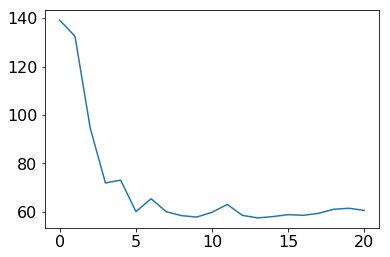

In [12]:
plt.plot(range(num_epochs), loss_epoch)
plt.show()

In [ ]:
loss_epoch

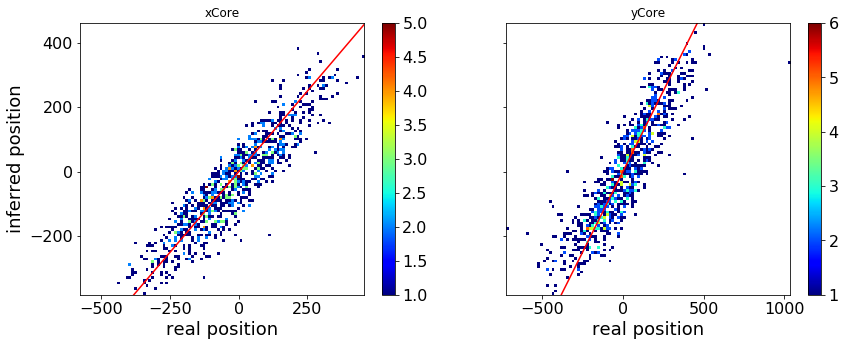

In [13]:
#histogram definition
bins = [100,100] # number of bins

cm = plt.cm.jet
cm.set_under('w',1)
# histogram the data
f, (fig1, fig2) = plt.subplots(1, 2, sharey=True)
_, _, _, im1 = fig1.hist2d(pos[:, 0], pos_inferred[:, 0], bins=bins, cmap=cm, cmin=1)
fig1.plot([-500, 0, 500], [-500, 0, 500],'r')
fig1.set_title('xCore')
fig1.set_xlabel('real position')
fig1.set_ylabel('inferred position')
_, _, _, im2 = fig2.hist2d(pos[:, 1], pos_inferred[:, 1], bins=bins, cmap=cm, cmin=1)
fig2.plot([-500, 0, 500], [-500, 0, 500],'r')
fig2.set_title('yCore')
fig2.set_xlabel('real position')
f.colorbar(im1, ax=fig1)   
f.colorbar(im2, ax=fig2)
f.set_figwidth(14)
f.set_figheight(5)
plt.show()

In [ ]:
f.close()